In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

train_dir = r'C:\Users\cwb01\Downloads\deep_learning_project (2)\deep_learning_project\train_images'
test_dir = r'C:\Users\cwb01\Downloads\deep_learning_project (2)\deep_learning_project\test_images'

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2
batch_size = 32

num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [6]:
import torch.optim as optim


net = Net()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


num_epochs = 10  
train_losses = []

for epoch in range(num_epochs):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  
        inputs, labels = data

        
        optimizer.zero_grad()

        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        if i % 100 == 99:  
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    
    train_losses.append(running_loss / len(train_loader))

print('Finished Training')


PATH = './face_detection_net.pth'
torch.save(net.state_dict(), PATH)


[Epoch 1, Batch 100] loss: 0.676
[Epoch 1, Batch 200] loss: 0.628
[Epoch 1, Batch 300] loss: 0.616
[Epoch 1, Batch 400] loss: 0.608
[Epoch 1, Batch 500] loss: 0.617
[Epoch 1, Batch 600] loss: 0.609
[Epoch 1, Batch 700] loss: 0.608
[Epoch 1, Batch 800] loss: 0.604
[Epoch 1, Batch 900] loss: 0.606
[Epoch 1, Batch 1000] loss: 0.603
[Epoch 1, Batch 1100] loss: 0.591
[Epoch 1, Batch 1200] loss: 0.589
[Epoch 1, Batch 1300] loss: 0.589
[Epoch 1, Batch 1400] loss: 0.578
[Epoch 1, Batch 1500] loss: 0.550
[Epoch 1, Batch 1600] loss: 0.497
[Epoch 1, Batch 1700] loss: 0.409
[Epoch 1, Batch 1800] loss: 0.309
[Epoch 1, Batch 1900] loss: 0.304
[Epoch 1, Batch 2000] loss: 0.273
[Epoch 1, Batch 2100] loss: 0.246
[Epoch 1, Batch 2200] loss: 0.225
[Epoch 2, Batch 100] loss: 0.212
[Epoch 2, Batch 200] loss: 0.192
[Epoch 2, Batch 300] loss: 0.219
[Epoch 2, Batch 400] loss: 0.175
[Epoch 2, Batch 500] loss: 0.174
[Epoch 2, Batch 600] loss: 0.162
[Epoch 2, Batch 700] loss: 0.154
[Epoch 2, Batch 800] loss: 0.1

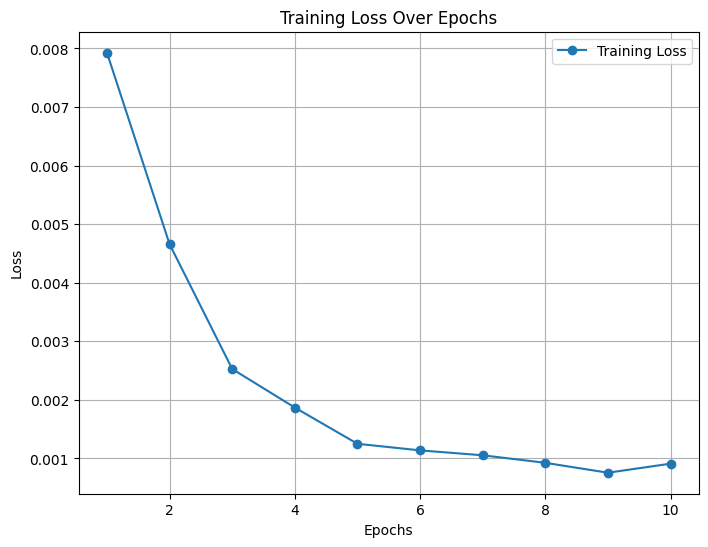

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.xlabel('Epochs')  
plt.ylabel('Loss') 
plt.title('Training Loss Over Epochs')  
plt.legend()
plt.grid()
plt.show()


In [7]:
import torch

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the 10000 test images: 92 %


In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(valid_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.0194, Val Loss: 0.0193, Train Acc: 99.33%, Val Acc: 99.30%
Epoch 2/10, Train Loss: 0.0175, Val Loss: 0.0190, Train Acc: 99.40%, Val Acc: 99.30%
Epoch 3/10, Train Loss: 0.0158, Val Loss: 0.0332, Train Acc: 99.45%, Val Acc: 98.79%
Epoch 4/10, Train Loss: 0.0138, Val Loss: 0.0204, Train Acc: 99.51%, Val Acc: 99.30%
Epoch 5/10, Train Loss: 0.0137, Val Loss: 0.0213, Train Acc: 99.53%, Val Acc: 99.25%
Epoch 6/10, Train Loss: 0.0120, Val Loss: 0.0151, Train Acc: 99.59%, Val Acc: 99.44%
Epoch 7/10, Train Loss: 0.0109, Val Loss: 0.0146, Train Acc: 99.63%, Val Acc: 99.45%
Epoch 8/10, Train Loss: 0.0101, Val Loss: 0.0152, Train Acc: 99.66%, Val Acc: 99.47%
Epoch 9/10, Train Loss: 0.0099, Val Loss: 0.0140, Train Acc: 99.66%, Val Acc: 99.51%
Epoch 10/10, Train Loss: 0.0095, Val Loss: 0.0138, Train Acc: 99.69%, Val Acc: 99.53%


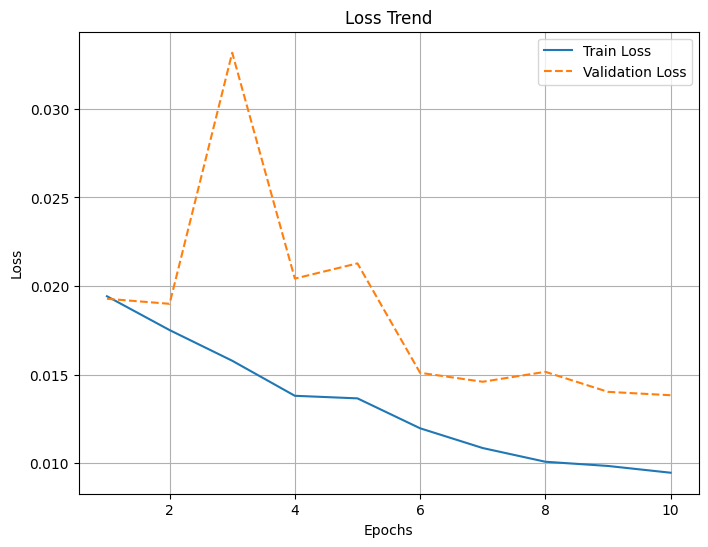

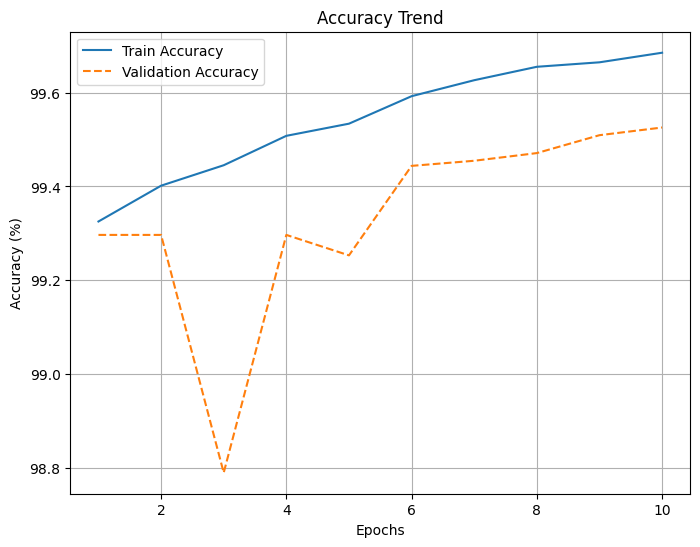

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Trend')
plt.legend()
plt.grid()
plt.show()


In [14]:
!pip install scikit-learn


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.8 kB 1.4 MB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB 7.9 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/11.1 MB 8.4 MB/s eta 0:00:02
   --- ------------------------------------ 1.1/11.1 MB 8.5 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/11.1 MB 8.3 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.1 MB 8.4 MB/s eta 0:00:02
   ------- -------------------------------- 2.2/11.1 MB 8.3 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.1 MB 8.2 MB/s eta 0:00:02
   ---------- ----------------------------- 3.0/11.1 MB 8.2 MB/s eta 0:00:01
   ----------- ---------------------------- 3.3/11.1 MB 8.2 MB/s eta 0:00:01
   --


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\cwb01\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


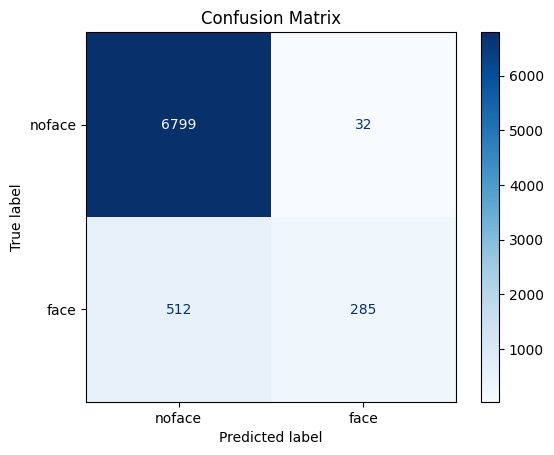

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

all_labels = []
all_predictions = []

net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
